# Using CellTypist for cell type classification
This notebook showcases the cell type classification for scRNA-seq query data by retrieving the most likely cell type labels from either the built-in CellTypist models or the user-trained custom models.

Only the main steps and key parameters are introduced in this notebook. Refer to detailed [Usage](https://github.com/Teichlab/celltypist#usage) if you want to learn more.

## Install CellTypist

In [1]:
!pip install celltypist

     |████████████████████████████████| 5.0 MB 16.4 MB/s eta 0:00:01


In [2]:
import scanpy as sc

In [3]:
import celltypist
from celltypist import models

## Download a scRNA-seq dataset of 2,000 immune cells

In [4]:
adata_2000 = sc.read('celltypist_demo_folder/demo_2000_cells.h5ad', backup_url = 'https://celltypist.cog.sanger.ac.uk/Notebook_demo_data/demo_2000_cells.h5ad')

  0%|          | 0.00/34.1M [00:00<?, ?B/s]

This dataset includes 2,000 cells and 18,950 genes collected from different studies, thereby showing the practical applicability of CellTypist.

In [5]:
adata_2000.shape

(2000, 18950)

The expression matrix (`adata_2000.X`) is pre-processed (and required) as log1p normalised expression to 10,000 counts per cell (this matrix can be alternatively stashed in `.raw.X`).

In [6]:
adata_2000.X.expm1().sum(axis = 1)

matrix([[10000.   ],
        [10000.002],
        [10000.   ],
        ...,
        [10000.   ],
        [10000.   ],
        [10000.   ]], dtype=float32)

Some pre-assigned cell type labels are also in the data, which will be compared to the predicted labels from CellTypist later.

In [7]:
adata_2000.obs

,cell_type
cell1,Plasma cells
cell2,Plasma cells
cell3,Plasma cells
cell4,Plasma cells
cell5,Plasma cells
...,...
cell1996,Neutrophil-myeloid progenitor
cell1997,Neutrophil-myeloid progenitor
cell1998,Neutrophil-myeloid progenitor
cell1999,Neutrophil-myeloid progenitor


## Assign cell type labels using a CellTypist built-in model
In this section, we show the procedure of transferring cell type labels from built-in models to the query dataset.

Download the latest CellTypist models.

In [8]:
# Enabling `force_update = True` will overwrite existing (old) models.
models.download_models(force_update = True)

📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
📚 Total models in list: 7
📂 Storing models in /home/jovyan/.celltypist/data/models
💾 Downloading model [1/7]: Immune_All_Low.pkl
💾 Downloading model [2/7]: Immune_All_High.pkl
💾 Downloading model [3/7]: Immune_All_PIP.pkl
💾 Downloading model [4/7]: Immune_All_AddPIP.pkl
💾 Downloading model [5/7]: Cells_Intestinal_Tract.pkl
💾 Downloading model [6/7]: Cells_Lung_Airway.pkl
💾 Downloading model [7/7]: Nuclei_Lung_Airway.pkl


All models are stored in `models.models_path`.

In [9]:
models.models_path

'/home/jovyan/.celltypist/data/models'

Get an overview of the models and what they represent.

In [10]:
models.models_description()

👉 Detailed model information can be found at `https://www.celltypist.org/models`


,model,description
0,Immune_All_Low.pkl,immune sub-populations combined from 20 tissue...
1,Immune_All_High.pkl,immune populations combined from 20 tissues of...
2,Immune_All_PIP.pkl,immune cell types combined from 16 adult human...
3,Immune_All_AddPIP.pkl,immune cell types combined from >20 human tiss...
4,Cells_Intestinal_Tract.pkl,"intestinal cells from fetal, pediatric and adu..."
5,Cells_Lung_Airway.pkl,cell populations from scRNA-seq of five locati...
6,Nuclei_Lung_Airway.pkl,cell populations from snRNA-seq of five locati...


Choose the model you want to employ, for example, the model with all tissues combined containing low-hierarchy (high-resolution) cell types/subtypes.

In [11]:
# Indeed, the `model` argument defaults to `Immune_All_Low.pkl`.
model = models.Model.load(model = 'Immune_All_Low.pkl')

This model contains 91 cell states.

In [12]:
model.cell_types

array(['B cells', 'CD16+ NK cells', 'CD16- NK cells', 'CD8a/a',
       'CD8a/b(entry)', 'CMP', 'Classical monocytes', 'Cycling B cells',
       'Cycling DCs', 'Cycling NK cells', 'Cycling T cells',
       'Cycling gamma-delta T cells', 'Cycling monocytes',
       'Cytotoxic T cells', 'DC', 'DC precursor', 'DC1', 'DC2', 'DC3',
       'Double-negative thymocytes', 'Double-positive thymocytes', 'ELP',
       'ETP', 'Early MK', 'Early erythroid', 'Early lymphoid/T lymphoid',
       'Endothelial cells', 'Epithelial cells', 'Erythrocytes',
       'Fibroblasts', 'Follicular B cells', 'Follicular helper T cells',
       'GMP', 'Germinal center B cells', 'Granulocytes', 'HSC/MPP',
       'Helper T cells', 'Hofbauer cells', 'ILC', 'ILC precursor', 'ILC1',
       'ILC2', 'ILC3', 'Immature B cells', 'Kidney-resident macrophages',
       'Kupffer cells', 'Late erythroid', 'MAIT cells', 'MEMP', 'MNP',
       'Macrophages', 'Mast cells', 'Megakaryocyte precursor',
       'Megakaryocyte-erythroid-mast

Some model meta-information.

In [13]:
model.description

{'date': '2021-10-27 15:20:55.163288',
 'details': 'immune sub-populations combined from 20 tissues of 19 studies',
 'url': 'https://celltypist.cog.sanger.ac.uk/models/Pan_Immune_CellTypist/v1/Immune_All_Low.pkl',
 'source': 'https://doi.org/10.1101/2021.04.28.441762',
 'version': 'v1',
 'number_celltypes': 91}

Transfer cell type labels from this model to the query dataset.

In [14]:
# Not run; predict cell identities using this loaded model.
#predictions = celltypist.annotate(adata_2000, model = model, majority_voting = True)
# Alternatively, just specify the model name (recommended as this ensures the model is intact every time it is loaded).
predictions = celltypist.annotate(adata_2000, model = 'Immune_All_Low.pkl', majority_voting = True)

🔬 Input data has 2000 cells and 18950 genes
🔗 Matching reference genes in the model
🧬 3278 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


By default (`majority_voting = False`), CellTypist will infer the identity of each query cell independently. This leads to raw predicted cell type labels, and usually finishes within seconds or minutes depending on the size of the query data. You can also turn on the majority-voting classifier (`majority_voting = True`), which refines cell identities within local subclusters after an over-clustering approach at the cost of increased runtime.

The results include both predicted cell type labels (`predicted_labels`), over-clustering result (`over_clustering`), and predicted labels after majority voting in local subclusters (`majority_voting`). Note in the `predicted_labels`, each query cell gets its inferred label by choosing the most probable cell type among all possible cell types in the given model.

In [15]:
predictions.predicted_labels

,predicted_labels,over_clustering,majority_voting
cell1,Plasma cells,42,Plasma cells
cell2,Plasma cells,14,Plasma cells
cell3,Plasma cells,37,gamma-delta T cells
cell4,Plasma cells,2,Plasma cells
cell5,Plasma cells,2,Plasma cells
...,...,...,...
cell1996,Neutrophil-myeloid progenitor,10,Neutrophil-myeloid progenitor
cell1997,Neutrophil-myeloid progenitor,28,Neutrophil-myeloid progenitor
cell1998,Neutrophil-myeloid progenitor,27,Neutrophil-myeloid progenitor
cell1999,Neutrophil-myeloid progenitor,28,Neutrophil-myeloid progenitor


Transform the prediction result into an `AnnData`.

In [16]:
# Get an `AnnData` with predicted labels embedded into the cell metadata columns.
adata = predictions.to_adata()

Compared to `adata_2000`, the new `adata` has additional prediction information in `adata.obs` (`predicted_labels`, `over_clustering`, `majority_voting` and `conf_score`). Of note, all these columns can be prefixed with a specific string by setting `prefix` in `to_adata`.

In [17]:
adata.obs

,cell_type,predicted_labels,over_clustering,majority_voting,conf_score
cell1,Plasma cells,Plasma cells,42,Plasma cells,0.996814
cell2,Plasma cells,Plasma cells,14,Plasma cells,0.995119
cell3,Plasma cells,Plasma cells,37,gamma-delta T cells,0.991911
cell4,Plasma cells,Plasma cells,2,Plasma cells,0.995159
cell5,Plasma cells,Plasma cells,2,Plasma cells,0.995717
...,...,...,...,...,...
cell1996,Neutrophil-myeloid progenitor,Neutrophil-myeloid progenitor,10,Neutrophil-myeloid progenitor,0.724281
cell1997,Neutrophil-myeloid progenitor,Neutrophil-myeloid progenitor,28,Neutrophil-myeloid progenitor,0.977658
cell1998,Neutrophil-myeloid progenitor,Neutrophil-myeloid progenitor,27,Neutrophil-myeloid progenitor,0.843348
cell1999,Neutrophil-myeloid progenitor,Neutrophil-myeloid progenitor,28,Neutrophil-myeloid progenitor,0.955746


In addition to this meta information added, the neighborhood graph constructed during over-clustering is also stored in the `adata` 
(If a pre-calculated neighborhood graph is already present in the `AnnData`, this graph construction step will be skipped).  
This graph can be used to derive the cell embeddings, such as the UMAP coordinates.

In [18]:
# If the UMAP or any cell embeddings are already available in the `AnnData`, skip this command.
sc.tl.umap(adata)

Visualise the prediction results.

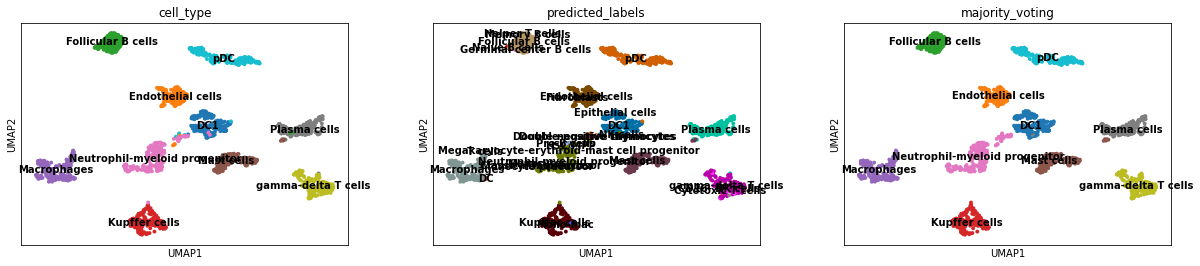

In [19]:
sc.pl.umap(adata, color = ['cell_type', 'predicted_labels', 'majority_voting'], legend_loc = 'on data')

Actually, you may not need to explicitly convert `predictions` output by `celltypist.annotate` into an `AnnData` as above. A more useful way is to use the visualisation function `celltypist.dotplot`, which quantitatively compares the CellTypist prediction result (e.g. `majority_voting` here) with the cell types pre-defined in the `AnnData` (here `cell_type`). You can also change the value of `use_as_prediction` to `predicted_labels` to compare the raw prediction result with the pre-defined cell types.

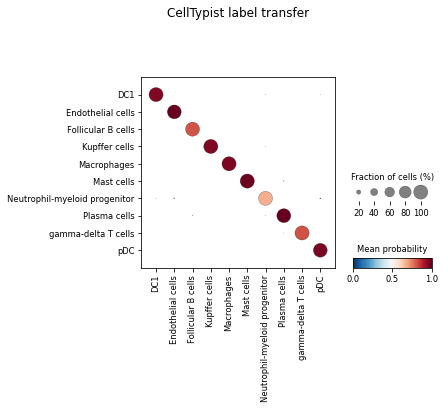

In [20]:
celltypist.dotplot(predictions, use_as_reference = 'cell_type', use_as_prediction = 'majority_voting')

For each pre-defined cell type (each column from the dot plot), this plot shows how it can be 'decomposed' into different cell types predicted by CellTypist (rows).

## Assign cell type labels using a custom model
In this section, we show the procedure of generating a custom model and transferring labels from the model to the query data.

Use previously downloaded dataset of 2,000 immune cells as the training set.

In [21]:
adata_2000 = sc.read('celltypist_demo_folder/demo_2000_cells.h5ad', backup_url = 'https://celltypist.cog.sanger.ac.uk/Notebook_demo_data/demo_2000_cells.h5ad')

Download another scRNA-seq dataset of 400 immune cells as a query.

In [22]:
adata_400 = sc.read('celltypist_demo_folder/demo_400_cells.h5ad', backup_url = 'https://celltypist.cog.sanger.ac.uk/Notebook_demo_data/demo_400_cells.h5ad')

  0%|          | 0.00/7.62M [00:00<?, ?B/s]

Derive a custom model by training the data using the `celltypist.train` function.

In [23]:
# The `cell_type` in `adata_2000.obs` will be used as cell type labels for training.
new_model = celltypist.train(adata_2000, labels = 'cell_type')

🍳 Preparing data before training
✂️ 2749 non-expressed genes are filtered out
⚖️ Scaling input data
🏋️ Training data using logistic regression
✅ Model training done!


By default, data is trained using a traditional logistic regression classifier. This classifier is well suited to datasets of small or intermediate sizes (as an empirical estimate, <= 100k cells), and usually leads to an unbiased probability range with less parameter tuning. Among the training parameters, three important ones are `solver` which (if not specified by the user) is selected based on the size of the input data by CellTypist, `C` which sets the inverse of L2 regularisation strength, and `max_iter` which controls the maximum number of iterations before reaching the minimum of the cost function. Other (hyper)parameters from [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) are also applicable in the `train` function.

When the dimensions of the input data are large, training may take longer time even with CPU parallelisation (achieved by the `n_jobs` argument). To reduce the training time as well as to add some randomness to the classifier's solution, a stochastic gradient descent (SGD) logistic regression classifier can be enabled by `use_SGD = True`.

In [24]:
# For illustration purpose; below is not run for this small training data.
#new_model = celltypist.train(adata_2000, labels = 'cell_type', use_SGD = True)

A logistic regression classifier with SGD learning reduces the training burden dramatically and has a comparable performance versus a traditional logistic regression classifier. A minor caveat is that more careful model parameter tuning may be needed if you want to utilise the probability values from the model for scoring cell types in the prediction step (the selection of the most likely cell type for each query cell in this notebook is not influenced however). Among the training parameters, two important ones are `alpha` which sets the L2 regularisation strength and `max_iter` which controls the maximum number of iterations. Other (hyper)parameters from [SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) are also applicable in the `train` function.

When the training data contains a huge number of cells (for example >500k cells) or more randomness in selecting cells for training is needed, you may consider using the mini-batch version of the SGD logistic regression classifier by specifying `use_SGD = True` and `mini_batch = True`. As a result, in each epoch (default to 10 epochs, `epochs = 10`), cells are binned into equal-sized (the size is default to 1000, `batch_size = 1000`) random batches, and are trained in a batch-by-batch manner (default to 100 batches, `batch_number = 100`).

In [25]:
# For illustration purpose; below is not run for this small training data.
#new_model = celltypist.train(adata_2000, labels = 'cell_type', use_SGD = True, mini_batch = True)

This custom model can be manipulated as with other CellTypist built-in models. First, save this model locally.

In [26]:
# Save the model.
new_model.write('celltypist_demo_folder/model_from_immune2000.pkl')

You can load this model by `models.Model.load`.

In [27]:
new_model = models.Model.load('celltypist_demo_folder/model_from_immune2000.pkl')

Next, we use this model to predict the query dataset of 400 immune cells.

In [28]:
# Not run; predict the identity of each input cell with the new model.
#predictions = celltypist.annotate(adata_400, model = new_model, majority_voting = True)
# Alternatively, just specify the model path (recommended as this ensures the model is intact every time it is loaded).
predictions = celltypist.annotate(adata_400, model = 'celltypist_demo_folder/model_from_immune2000.pkl', majority_voting = True)

🔬 Input data has 400 cells and 18950 genes
🔗 Matching reference genes in the model
🧬 16201 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


In [29]:
adata = predictions.to_adata()

In [30]:
sc.tl.umap(adata)

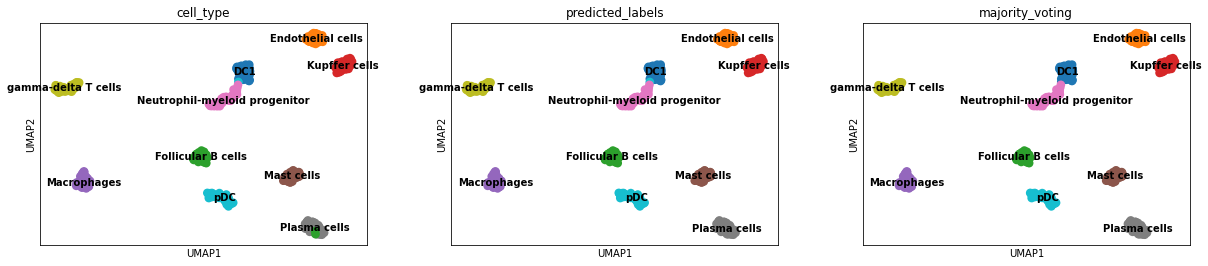

In [31]:
sc.pl.umap(adata, color = ['cell_type', 'predicted_labels', 'majority_voting'], legend_loc = 'on data')

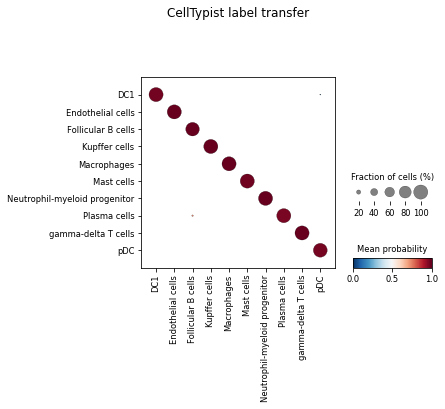

In [32]:
celltypist.dotplot(predictions, use_as_reference = 'cell_type', use_as_prediction = 'majority_voting')

## Examine expression of cell type-driving genes

Each model can be examined in terms of the driving genes for each cell type. Note these genes are only dependent on the model, say, the training dataset.

In [33]:
# Any model can be inspected.
# Here we load the previously saved model trained from 2,000 immune cells.
model = models.Model.load(model = 'celltypist_demo_folder/model_from_immune2000.pkl')

In [34]:
model.cell_types

array(['DC1', 'Endothelial cells', 'Follicular B cells', 'Kupffer cells',
       'Macrophages', 'Mast cells', 'Neutrophil-myeloid progenitor',
       'Plasma cells', 'gamma-delta T cells', 'pDC'], dtype=object)

Extract the matrix of gene weights across cell types.

In [35]:
weights = model.classifier.coef_
weights.shape

(10, 16201)

Top three driving genes of `Mast cells`.

In [36]:
mast_cell_weights = weights[model.cell_types == 'Mast cells']
top_3_genes = model.features[mast_cell_weights.argpartition(-3, axis = None)[-3:]]
top_3_genes

array(['CPA3', 'TPSAB1', 'TPSB2'], dtype=object)

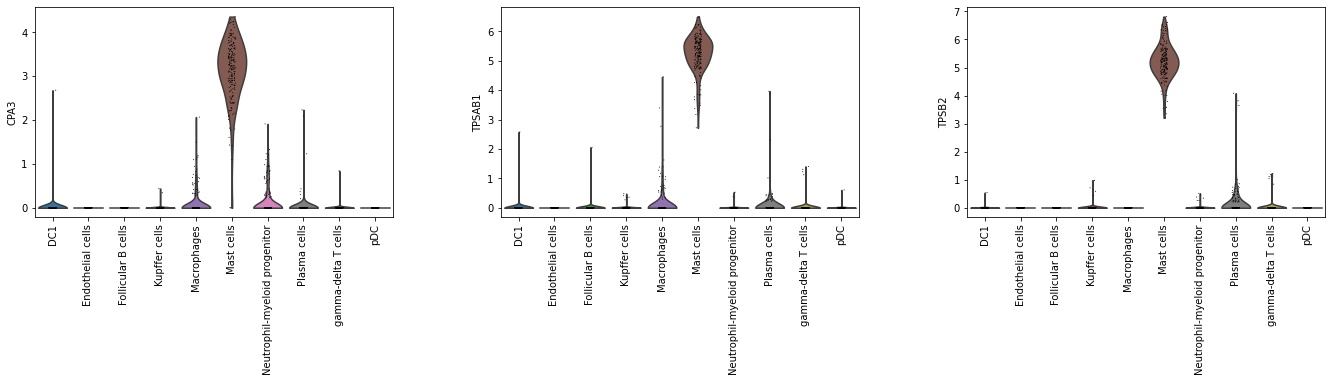

In [37]:
# Check expression of the three genes in the training set.
sc.pl.violin(adata_2000, top_3_genes, groupby = 'cell_type', rotation = 90)

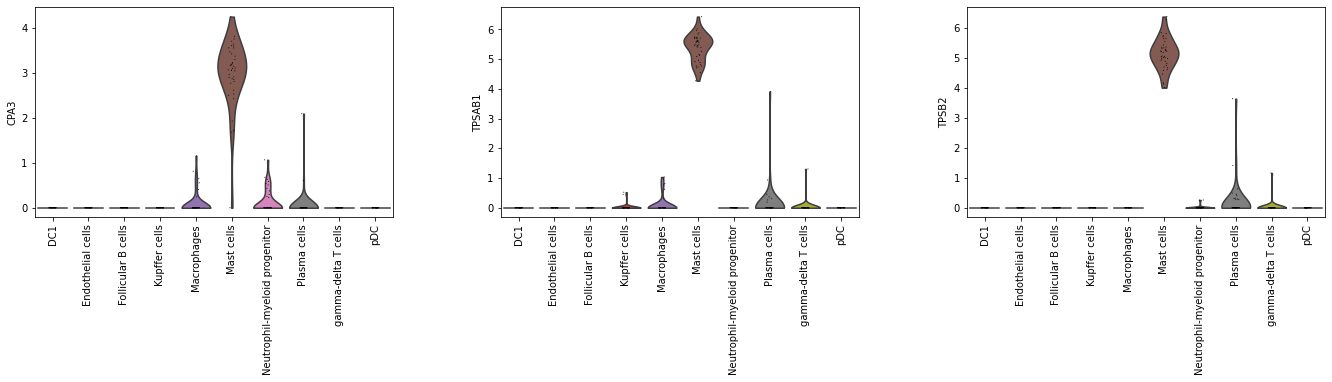

In [38]:
# Check expression of the three genes in the query set.
# Here we use `majority_voting` from CellTypist as the cell type labels for this dataset.
sc.pl.violin(adata_400, top_3_genes, groupby = 'majority_voting', rotation = 90)